# Avaliação estatitisca modelos machine learning

In [ ]:
!pip install scikit-posthocs
#https://pypi.org/project/scikit-posthocs/

# Versão Atual

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import friedmanchisquare, chi2, t, norm
from scikit_posthocs import posthoc_conover, posthoc_dunn, posthoc_nemenyi_friedman

class StatisticalAnalysis:
    def __init__(self, f1_scores_dict, alpha=0.05):
        """
        Classe para realizar Teste de Friedman e Pós-Testes de Diferença Crítica (Nemenyi, Conover e Bonferroni)
        utilizando exclusivamente a métrica F1-score.

        Parâmetros:
        - f1_scores_dict: dicionário contendo os nomes dos modelos e seus F1-scores por fold.
        - alpha: nível de significância estatística (padrão: 0.05).
        """
        self.f1_scores_dict = f1_scores_dict
        self.models = list(f1_scores_dict.keys())
        self.results_array = np.array(list(f1_scores_dict.values()))
        self.alpha = alpha
        self.N = len(next(iter(f1_scores_dict.values())))  # Número de folds (experimentos)
        self.k = len(self.models)  # Número de modelos testados
        self.df_friedman = self.k - 1  # Graus de liberdade para Friedman
        self.df_bonferroni = self.N * self.df_friedman  # Graus de liberdade para Bonferroni

        # Valores críticos
        self.valor_critico_friedman = chi2.ppf(1 - self.alpha, self.df_friedman)  # Qui-quadrado para Friedman
        self.q_bonferroni = t.ppf(1 - (self.alpha / (self.k * (self.k - 1) / 2)) / 2, self.df_bonferroni)  # t-Student para Bonferroni
        self.q_conover = norm.ppf(1 - self.alpha / 2)  # Normal para Conover
        self.q_nemenyi = self.get_q_nemenyi(self.k)  # Obtendo valor crítico de Nemenyi
        self.cd_nemenyi = self.q_nemenyi * np.sqrt(self.k * (self.k + 1) / (6 * self.N))  # Diferença Crítica (CD)


        # Exibir valores críticos
        print(f"Número de experimentos (N) = {self.N}")
        print(f"Número de modelos (k) = {self.k}")
        print(f"Graus de liberdade para Friedman = {self.df_friedman}")
        print(f"Valor crítico de Friedman (α={self.alpha}) = {self.valor_critico_friedman:.3f}")
        print(f"Valor crítico de Bonferroni (qα) = {self.q_bonferroni:.3f}")
        print(f"Valor crítico de Conover (qα) = {self.q_conover:.3f}")
        print(f"Valor crítico de Nemenyi (qα) = {self.q_nemenyi:.3f}")
        print(f"Diferença Crítica (CD) para Nemenyi = {self.cd_nemenyi:.3f}")


    def get_q_nemenyi(self, k):
        """Obtém o valor crítico q_0.05 da tabela do pós-teste de Nemenyi."""
        nemenyi_table = {
            2: 1.960, 3: 2.343, 4: 2.569, 5: 2.728, 6: 2.850,
            7: 2.949, 8: 3.031, 9: 3.102, 10: 3.164
        }
        return nemenyi_table.get(k, 3.164)  # Padrão: maior valor da tabela

    def friedman_test(self):
        """Executa o Teste de Friedman e retorna o valor de p"""
        statistic, p_value = friedmanchisquare(*self.results_array)
        print(f"\nTeste de Friedman (F1-score): estatística={statistic:.4f}, p-valor={p_value:.4f}")

        if statistic > self.valor_critico_friedman:
            print(f"Estatística de Friedman ({statistic:.4f}) > Valor crítico ({self.valor_critico_friedman:.3f}): **Rejeitamos H0** (há diferença significativa)")
        else:
            print(f"Estatística de Friedman ({statistic:.4f}) ≤ Valor crítico ({self.valor_critico_friedman:.3f}): **Não rejeitamos H0** (não há diferença significativa)")

        return p_value

    def nemenyi_test(self):
        """Executa o Pós-Teste de Nemenyi"""
        df_results = pd.DataFrame(self.results_array.T, columns=self.models)
        posthoc_res = posthoc_nemenyi_friedman(df_results)
        print("\nPós-Teste de Nemenyi:\n", posthoc_res)

        #self.plot_heatmap(posthoc_res, "Pós-Teste de Nemenyi - F1-score")
        self.plot_cd_diagram(posthoc_res, "Nemenyi")

        return posthoc_res

    def plot_cd_diagram(self, posthoc_matrix, test_type="Nemenyi"):
        """Gera um Diagrama de Diferença Crítica (CD Diagram)"""
        f1_means = {model: np.mean(scores) for model, scores in self.f1_scores_dict.items()}
        rankings = sorted(f1_means.items(), key=lambda x: x[1], reverse=True)

        plt.figure(figsize=(8, 4))
        plt.title(f"Diagrama de Diferença Crítica ({test_type})", fontsize=12)

        # Desenhar linha base e modelos
        y_pos = 1
        for i, (model, score) in enumerate(rankings):
            plt.scatter(score, y_pos, color="black", s=50)
            plt.text(score, y_pos + 0.1, model, ha='center', fontsize=10)
            y_pos += 1

        # Adicionar linha de Diferença Crítica (CD)
        plt.plot([rankings[0][1] - self.cd_nemenyi, rankings[0][1] + self.cd_nemenyi], [y_pos - 1.5, y_pos - 1.5], color="black", linewidth=2)
        plt.text(rankings[0][1], y_pos - 1.2, "CD", ha='center', fontsize=10, fontweight="bold")

        plt.xlabel("Ranking dos Modelos (Baseado no F1-score)")
        plt.yticks([])
        plt.grid(axis='x', linestyle="--", alpha=0.5)
        plt.show()

    def posthoc_tests(self, method="conover"):
        """Executa os pós-testes de Conover ou Bonferroni"""
        df_results = pd.DataFrame(self.f1_scores_dict)
        df_results = df_results.melt(var_name='group', value_name='value')

        if method == "conover":
            posthoc_res = posthoc_conover(df_results, val_col='value', group_col='group', p_adjust="holm")
            title = "Pós-Teste de Conover (Holm) - F1-score"
        elif method == "bonferroni":
            posthoc_res = posthoc_dunn(df_results, val_col='value', group_col='group', p_adjust="bonferroni")
            title = "Pós-Teste de Dunn (Bonferroni) - F1-score"
        else:
            raise ValueError("Método inválido. Escolha 'conover' ou 'bonferroni'.")

        print(f"\n{title}:\n", posthoc_res)
        self.plot_heatmap(posthoc_res, title)
        return posthoc_res

    def plot_heatmap(self, posthoc_matrix, title="Pós-Teste Estatístico - F1-score"):
        """Gera um heatmap para visualizar os resultados do pós-teste"""
        plt.figure(figsize=(8, 6))
        sns.heatmap(posthoc_matrix, annot=True, cmap="coolwarm", fmt=".4f", linewidths=0.5)
        plt.title(title)
        plt.show()

    def plot_rankings(self):
        """Gera um gráfico de ranking dos modelos baseado no F1-score médio"""
        f1_means = {model: np.mean(scores) for model, scores in self.f1_scores_dict.items()}
        sorted_f1 = sorted(f1_means.items(), key=lambda x: x[1], reverse=True)

        plt.figure(figsize=(8, 5))
        sns.barplot(x=[x[1] for x in sorted_f1], y=[x[0] for x in sorted_f1], palette="viridis")
        plt.xlabel("Média do F1-score")
        plt.ylabel("Modelo")
        plt.title("Ranking dos Modelos com Base no F1-score")
        plt.xlim(0.55, 0.75)
        plt.show()



Número de experimentos (N) = 5
Número de modelos (k) = 5
Graus de liberdade para Friedman = 4
Valor crítico de Friedman (α=0.05) = 9.488
Valor crítico de Bonferroni (qα) = 3.153
Valor crítico de Conover (qα) = 1.960
Valor crítico de Nemenyi (qα) = 2.728
Diferença Crítica (CD) para Nemenyi = 2.728

Teste de Friedman (F1-score): estatística=14.8800, p-valor=0.0050
Estatística de Friedman (14.8800) > Valor crítico (9.488): **Rejeitamos H0** (há diferença significativa)

Pós-Teste de Nemenyi:
                                 facebook_vit-mae-base  facebook_vit-mae-large  \
facebook_vit-mae-base                        1.000000                0.751424   
facebook_vit-mae-large                       0.751424                1.000000   
google_vit-base-patch16-224                  0.265889                0.011994   
google_vit-large-patch32-384                 0.627659                0.070324   
facebook_deit-base-patch16-384               0.373481                0.022659   

                  

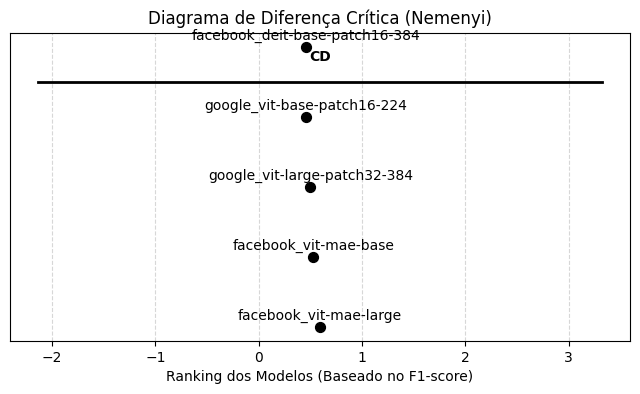


Pós-Teste de Conover (Holm) - F1-score:
                                 facebook_deit-base-patch16-384  \
facebook_deit-base-patch16-384                        1.000000   
facebook_vit-mae-base                                 0.156709   
facebook_vit-mae-large                                0.001745   
google_vit-base-patch16-224                           0.755201   
google_vit-large-patch32-384                          0.708587   

                                facebook_vit-mae-base  facebook_vit-mae-large  \
facebook_deit-base-patch16-384               0.156709                0.001745   
facebook_vit-mae-base                        1.000000                0.220074   
facebook_vit-mae-large                       0.220074                1.000000   
google_vit-base-patch16-224                  0.092621                0.000932   
google_vit-large-patch32-384                 0.645767                0.014189   

                                google_vit-base-patch16-224  \
facebook_de

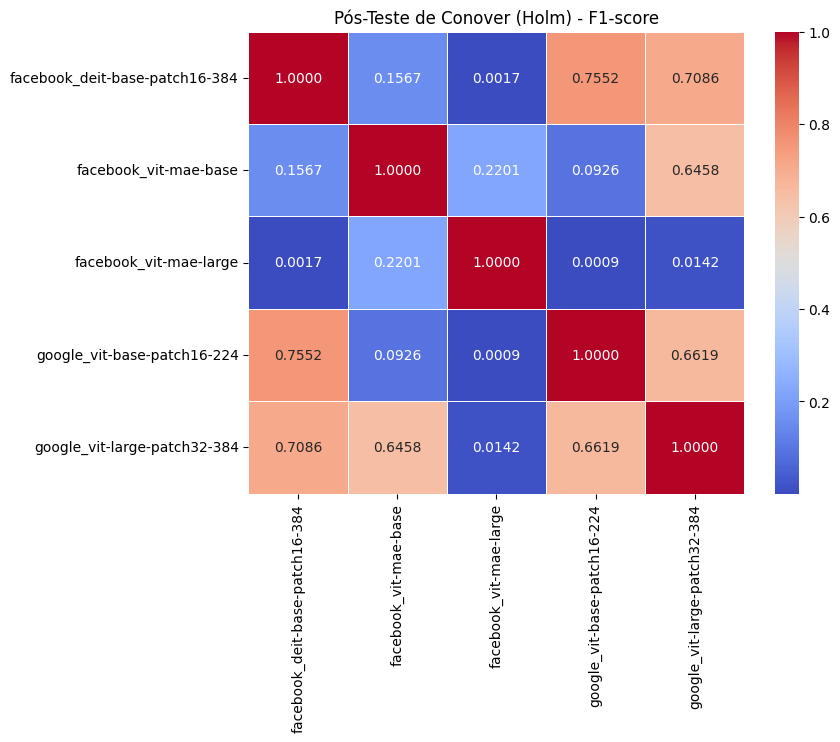

<ipython-input-2-2d07e23ccbfb>:132: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[x[1] for x in sorted_f1], y=[x[0] for x in sorted_f1], palette="viridis")


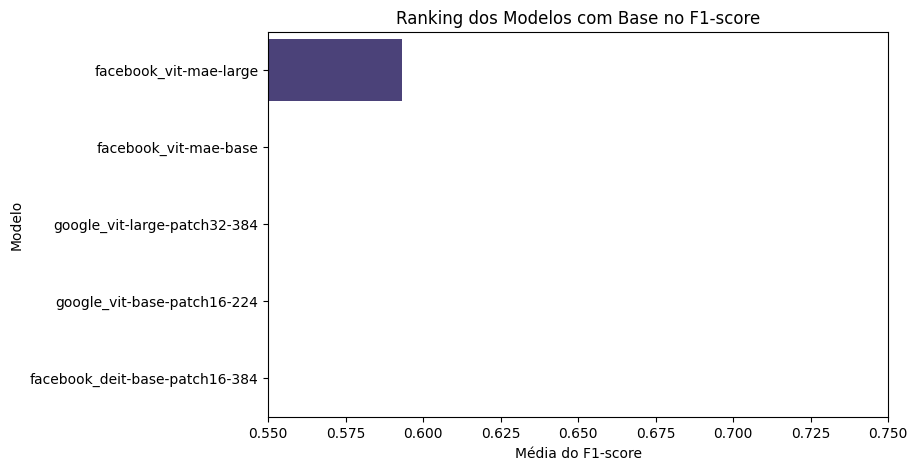

In [ ]:
# ------------------------------
# Exemplo de uso da classe
# ------------------------------





if __name__ == "__main__":
    f1_scores = {
        "facebook_vit-mae-base": [0.4976181137777584, 0.5738939804157195, 0.5327096752238822, 0.5161515635469061, 0.5242179034378522],
        "facebook_vit-mae-large": [0.5599959253142723, 0.6018729295971245, 0.5741766747184704, 0.6092834705265721, 0.6201362800164792],
        "google_vit-base-patch16-224":[0.45595495275129144, 0.4629782679612371, 0.5313646506711874, 0.4637626379543192, 0.3639620913628182],
        "google_vit-large-patch32-384": [0.47696110165735667, 0.4570572720828476, 0.5072172357338597, 0.5728776818988797, 0.4867498084990345],
        "facebook_deit-base-patch16-384": [0.37463171951663, 0.4596120769495382, 0.5314509079832401, 0.5085419366681986, 0.4030687403113032],
        #"resnet50": [0.45834325408965343, 0.4917311823183056, 0.4966061645089778, 0.501830315479528, 0.4859769521096753],
        #"resnet101": [0.3831108568522757, 0.37855905816263874, 0.409396784501398, 0.3976358313617702, 0.4035407873580546],
        #"resnet152": [0.407443320805029, 0.3944953881015262, 0.45261125868542745, 0.38459110172109173, 0.44951350903026777],
        #"efficientnetb4": [0.4771009751828166, 0.44650255855330573, 0.5018739503587366, 0.470005115283753, 0.44902634308005146],
        #"efficientnetb0": [0.508452831871046, 0.5581712902045382, 0.5535151093503496, 0.5072735988081256, 0.55884566939203],

    }

    analysis = StatisticalAnalysis(f1_scores)

    p_value = analysis.friedman_test()

    if p_value < 0.05:
        analysis.nemenyi_test()
        analysis.posthoc_tests("conover")
        analysis.plot_rankings()


# Versão Antiga

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import friedmanchisquare, chi2, t, norm
from scikit_posthocs import posthoc_conover, posthoc_dunn

class StatisticalAnalysis:
    def __init__(self, f1_scores_dict, alpha=0.05):
        """
        Classe para realizar Teste de Friedman e Pós-Testes de Diferença Crítica (Conover e Bonferroni)
        utilizando exclusivamente a métrica F1-score.

        Parâmetros:
        - f1_scores_dict: dicionário contendo os nomes dos modelos e seus F1-scores por fold.
        - alpha: nível de significância estatística (padrão: 0.05).
        """
        self.f1_scores_dict = f1_scores_dict
        self.models = list(f1_scores_dict.keys())
        self.results_array = np.array(list(f1_scores_dict.values()))
        self.alpha = alpha
        self.N = len(next(iter(f1_scores_dict.values())))  # Número de folds (experimentos)
        self.k = len(self.models)  # Número de modelos testados
        self.df_friedman = self.k - 1  # Graus de liberdade para Friedman
        self.df_bonferroni = self.N * self.df_friedman  # Graus de liberdade para Bonferroni

        # Valores críticos
        self.valor_critico_friedman = chi2.ppf(1 - self.alpha, self.df_friedman)  # Qui-quadrado para Friedman
        self.q_bonferroni = t.ppf(1 - (self.alpha / (self.k * (self.k - 1) / 2)) / 2, self.df_bonferroni)  # t-Student para Bonferroni
        self.q_conover = norm.ppf(1 - self.alpha / 2)  # Normal para Conover

        # Exibir valores críticos
        print(f"Número de experimentos (N) = {self.N}")
        print(f"Número de modelos (k) = {self.k}")
        print(f"Graus de liberdade para Friedman = {self.df_friedman}")
        print(f"Valor crítico de Friedman (α={self.alpha}) = {self.valor_critico_friedman:.3f}")
        print(f"Valor crítico de Bonferroni (qα) = {self.q_bonferroni:.3f}")
        print(f"Valor crítico de Conover (qα) = {self.q_conover:.3f}")

    def friedman_test(self):
        """Executa o Teste de Friedman e retorna o valor de p"""
        statistic, p_value = friedmanchisquare(*self.results_array)
        print(f"\nTeste de Friedman (F1-score): estatística={statistic:.4f}, p-valor={p_value:.4f}")

        if statistic > self.valor_critico_friedman:
            print(f"Estatística de Friedman ({statistic:.4f}) > Valor crítico ({self.valor_critico_friedman:.3f}): **Rejeitamos H0** (há diferença significativa)")
        else:
            print(f"Estatística de Friedman ({statistic:.4f}) ≤ Valor crítico ({self.valor_critico_friedman:.3f}): **Não rejeitamos H0** (não há diferença significativa)")

        return p_value

    def posthoc_tests(self, method="conover"):
        """Executa os pós-testes de Conover ou Bonferroni"""
        df_results = pd.DataFrame(self.f1_scores_dict)
        df_results = df_results.melt(var_name='group', value_name='value')

        if method == "conover":
            posthoc_res = posthoc_conover(df_results, val_col='value', group_col='group', p_adjust="holm")
            title = "Pós-Teste de Conover (Holm) - F1-score"
        elif method == "bonferroni":
            posthoc_res = posthoc_dunn(df_results, val_col='value', group_col='group', p_adjust="bonferroni")
            title = "Pós-Teste de Dunn (Bonferroni) - F1-score"
        else:
            raise ValueError("Método inválido. Escolha 'conover' ou 'bonferroni'.")

        print(f"\n{title}:\n", posthoc_res)
        return posthoc_res

    def format_results(self, posthoc_matrix):
        """Gera uma tabela indicando se há diferença significativa entre cada par de modelos"""
        comparisons = []
        superior_models = set()

        for i, model_a in enumerate(self.models):
            for j, model_b in enumerate(self.models):
                if i < j:
                    p_value = posthoc_matrix.loc[model_a, model_b]
                    if p_value < self.alpha:
                        comparisons.append(f"{model_a} vs {model_b} - Existe diferença significativa (p={p_value:.4f})")
                        superior_models.add(model_b if np.mean(self.f1_scores_dict[model_b]) > np.mean(self.f1_scores_dict[model_a]) else model_a)
                    else:
                        comparisons.append(f"{model_a} vs {model_b} - Não existe diferença significativa (p={p_value:.4f})")

        print("\n### Comparações Estatísticas (F1-score) ###")
        for comp in comparisons:
            print(comp)

        print("\n### Modelos Estatisticamente Superiores (F1-score) ###")
        for model in superior_models:
            print(f"- {model} é estatisticamente superior a pelo menos um outro modelo.")

        return comparisons, list(superior_models)

    def plot_heatmap(self, posthoc_matrix, title="Pós-Teste Estatístico - F1-score"):
        """Gera um heatmap para visualizar os resultados do pós-teste"""
        plt.figure(figsize=(8, 6))
        sns.heatmap(posthoc_matrix, annot=True, cmap="coolwarm", fmt=".4f", linewidths=0.5)
        plt.title(title)
        plt.show()



Número de experimentos (N) = 5
Número de modelos (k) = 4
Graus de liberdade para Friedman = 3
Valor crítico de Friedman (α=0.05) = 7.815
Valor crítico de Bonferroni (qα) = 3.036
Valor crítico de Conover (qα) = 1.960

Teste de Friedman (F1-score): estatística=15.0000, p-valor=0.0018
Estatística de Friedman (15.0000) > Valor crítico (7.815): **Rejeitamos H0** (há diferença significativa)

Há diferença significativa entre os modelos! Executando os pós-testes...


Pós-Teste de Conover (Holm) - F1-score:
                               facebook_vit-mae-base  facebook_vit-mae-large  \
facebook_vit-mae-base                  1.000000e+00            5.525225e-10   
facebook_vit-mae-large                 5.525225e-10            1.000000e+00   
google_vit-base-patch16-224            2.164342e-14            4.295269e-17   
google_vit-large-patch32-384           5.525225e-10            2.164342e-14   

                              google_vit-base-patch16-224  \
facebook_vit-mae-base                

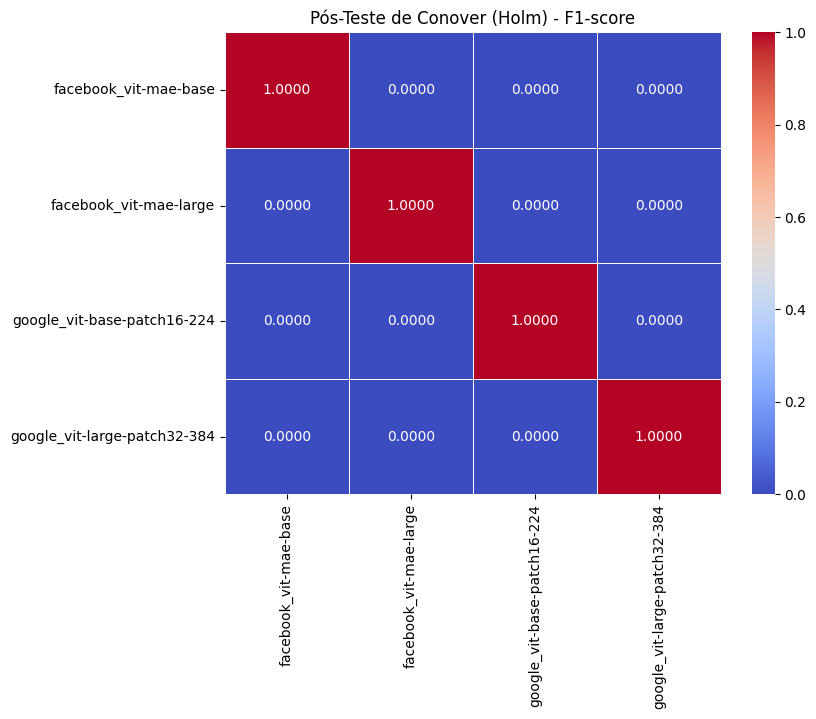


### Comparações Estatísticas (F1-score) ###
facebook_vit-mae-base vs facebook_vit-mae-large - Existe diferença significativa (p=0.0000)
facebook_vit-mae-base vs google_vit-base-patch16-224 - Existe diferença significativa (p=0.0000)
facebook_vit-mae-base vs google_vit-large-patch32-384 - Existe diferença significativa (p=0.0000)
facebook_vit-mae-large vs google_vit-base-patch16-224 - Existe diferença significativa (p=0.0000)
facebook_vit-mae-large vs google_vit-large-patch32-384 - Existe diferença significativa (p=0.0000)
google_vit-base-patch16-224 vs google_vit-large-patch32-384 - Existe diferença significativa (p=0.0000)

### Modelos Estatisticamente Superiores (F1-score) ###
- facebook_vit-mae-base é estatisticamente superior a pelo menos um outro modelo.
- facebook_vit-mae-large é estatisticamente superior a pelo menos um outro modelo.
- google_vit-large-patch32-384 é estatisticamente superior a pelo menos um outro modelo.

### Tabela Final de Modelos Estatisticamente Superiores 

In [ ]:
# ------------------------------
# Exemplo de uso da classe com F1-score
# ------------------------------
if __name__ == "__main__":
    f1_scores = {
        "facebook_vit-mae-base": [0.6674344640814408, 0.6674344640814408, 0.6674344640814408, 0.6674344640814408, 0.6674344640814408],
        "facebook_vit-mae-large": [0.7017189775250512, 0.7017189775250512, 0.7017189775250512, 0.7017189775250512, 0.7017189775250512],
        "google_vit-base-patch16-224": [0.6029708271339207, 0.6029708271339207, 0.6029708271339207, 0.6029708271339207, 0.6029708271339207],
        "google_vit-large-patch32-384": [0.6368952770294929, 0.6415274820963689, 0.6415274820963689, 0.6415274820963689, 0.6415274820963689]
    }

    analysis = StatisticalAnalysis(f1_scores)

    # Teste de Friedman
    p_value = analysis.friedman_test()

    if p_value < 0.05:
        print("\nHá diferença significativa entre os modelos! Executando os pós-testes...\n")

        conover_res = analysis.posthoc_tests(method="conover")
        analysis.plot_heatmap(conover_res, title="Pós-Teste de Conover (Holm) - F1-score")
        comparisons, superior_models = analysis.format_results(conover_res)

        df_summary = pd.DataFrame({"Modelo": analysis.models, "Superior a outros?": ["Sim" if model in superior_models else "Não" for model in analysis.models]})
        print("\n### Tabela Final de Modelos Estatisticamente Superiores (F1-score) ###")
        print(df_summary.to_string(index=False))

    else:
        print("\nNenhuma diferença estatisticamente significativa encontrada entre os modelos.")


# Passo 1: Criar um Boxplot dos F1-Scores

O boxplot permite visualizar a dispersão dos F1-scores por fold, ajudando a identificar a estabilidade dos modelos.



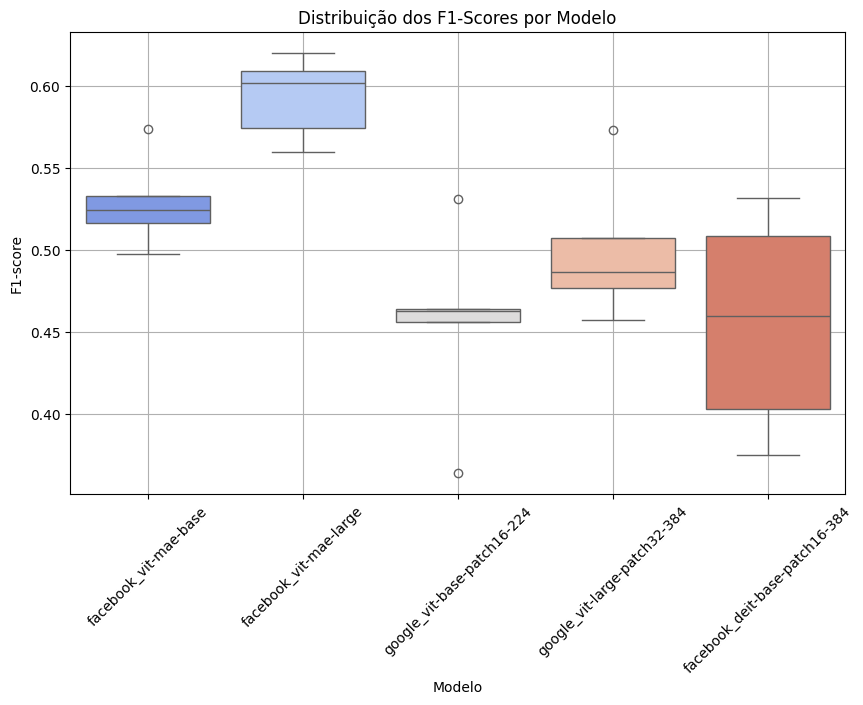

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# F1-scores por modelo
f1_scores = {
        "facebook_vit-mae-base": [0.4976181137777584, 0.5738939804157195, 0.5327096752238822, 0.5161515635469061, 0.5242179034378522],
        "facebook_vit-mae-large": [0.5599959253142723, 0.6018729295971245, 0.5741766747184704, 0.6092834705265721, 0.6201362800164792],
        "google_vit-base-patch16-224":[0.45595495275129144, 0.4629782679612371, 0.5313646506711874, 0.4637626379543192, 0.3639620913628182],
        "google_vit-large-patch32-384": [0.47696110165735667, 0.4570572720828476, 0.5072172357338597, 0.5728776818988797, 0.4867498084990345],
        "facebook_deit-base-patch16-384": [0.37463171951663, 0.4596120769495382, 0.5314509079832401, 0.5085419366681986, 0.4030687403113032],
        #"resnet50": [0.45834325408965343, 0.4917311823183056, 0.4966061645089778, 0.501830315479528, 0.4859769521096753],
        #"resnet101": [0.3831108568522757, 0.37855905816263874, 0.409396784501398, 0.3976358313617702, 0.4035407873580546],
        #"resnet152": [0.407443320805029, 0.3944953881015262, 0.45261125868542745, 0.38459110172109173, 0.44951350903026777],
        #"efficientnetb4": [0.4771009751828166, 0.44650255855330573, 0.5018739503587366, 0.470005115283753, 0.44902634308005146],
        #"efficientnetb0": [0.508452831871046, 0.5581712902045382, 0.5535151093503496, 0.5072735988081256, 0.55884566939203],

    }

# Converter para DataFrame
import pandas as pd
df_f1 = pd.DataFrame(f1_scores)

# Criar o Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_f1, palette="coolwarm")
plt.title("Distribuição dos F1-Scores por Modelo")
plt.ylabel("F1-score")
plt.xlabel("Modelo")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


# 📢 Interpretação:
✔ Modelos com boxplots mais compactos têm desempenho mais estável.
✔ Modelos com boxplots muito dispersos podem ter inconsistências entre os folds.

# Passo 2: Criar um Heatmap da Matriz de p-Valores

Agora vamos criar um heatmap da matriz de p-valores do Pós-Teste de Conover para visualizar quais modelos são significativamente diferentes.



## 📢 Interpretação:
✔ Valores muito pequenos (p < 0.05) indicam que há diferença estatisticamente significativa entre os modelos.
✔ Se um modelo tivesse valores altos (> 0.05) com outros modelos, ele não teria diferença estatística com eles.

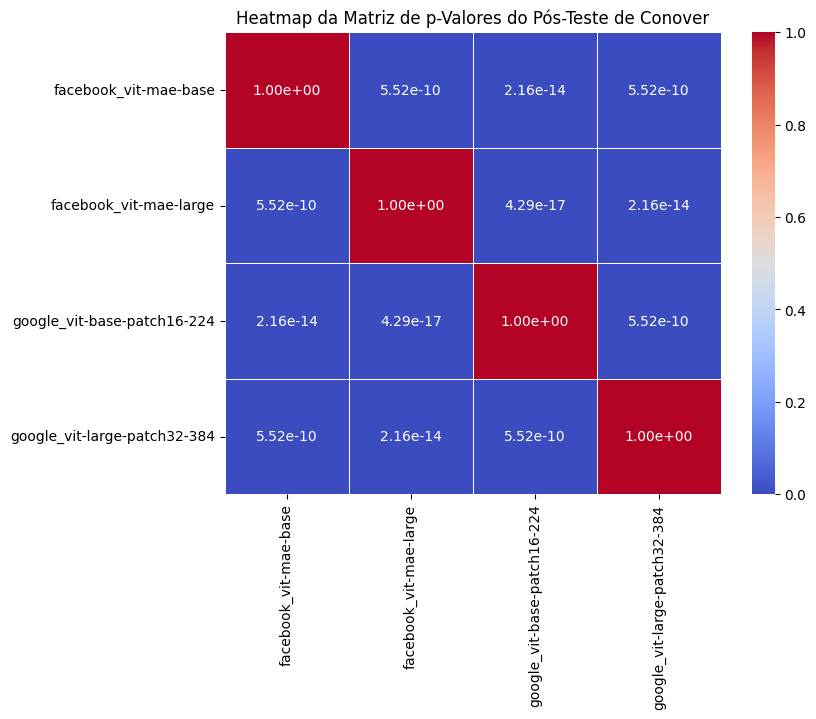

In [ ]:
import numpy as np

# Matriz de p-valores do Pós-Teste de Conover (exemplo)
p_values_matrix = np.array([
    [1.00, 5.52e-10, 2.16e-14, 5.52e-10],
    [5.52e-10, 1.00, 4.29e-17, 2.16e-14],
    [2.16e-14, 4.29e-17, 1.00, 5.52e-10],
    [5.52e-10, 2.16e-14, 5.52e-10, 1.00]
])

# Criar DataFrame para visualização
model_names = ["facebook_vit-mae-base", "facebook_vit-mae-large",
               "google_vit-base-patch16-224", "google_vit-large-patch32-384"]
df_p_values = pd.DataFrame(p_values_matrix, index=model_names, columns=model_names)

# Criar o Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df_p_values, annot=True, fmt=".2e", cmap="coolwarm", linewidths=0.5)
plt.title("Heatmap da Matriz de p-Valores do Pós-Teste de Conover")
plt.show()


# 📊  Passo 3: Criar um Gráfico de Ranking dos Modelos

Agora vamos visualizar o ranking dos modelos com base no F1-score médio.

## 📢 Interpretação:
✔ O modelo no topo do ranking tem o melhor F1-score médio.
✔ Se a diferença entre os modelos for muito pequena, pode ser interessante considerar outras métricas (precisão, recall) ou eficiência computacional.


<ipython-input-5-8ec7173dc9f1>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=f1_means_sorted, y=model_names, palette="magma")


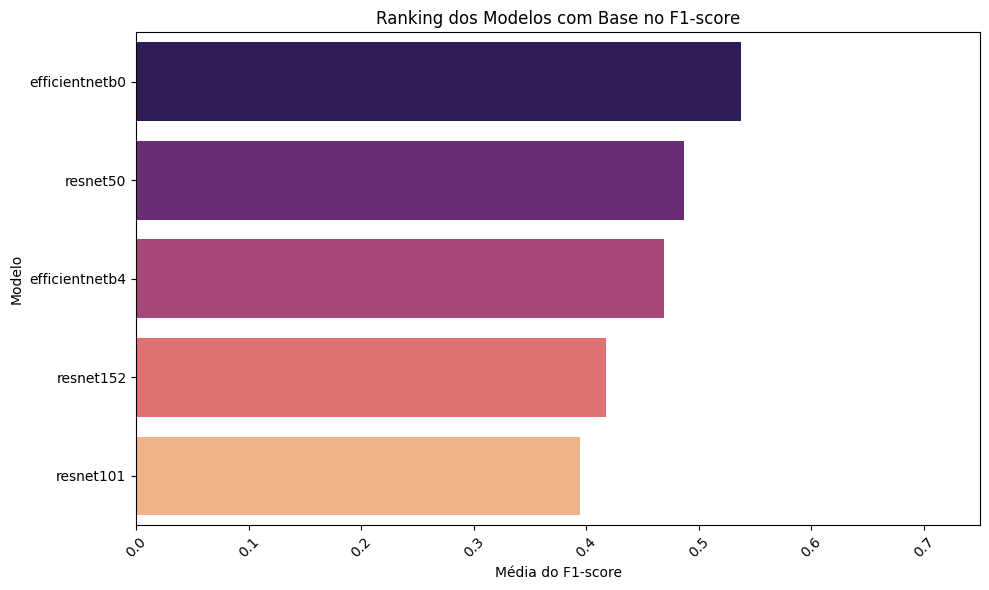

In [ ]:
# Média do F1-score por modelo
f1_scores = {
        #"facebook_vit-mae-base": [0.4976181137777584, 0.5738939804157195, 0.5327096752238822, 0.5161515635469061, 0.5242179034378522],
        #"facebook_vit-mae-large": [0.5599959253142723, 0.6018729295971245, 0.5741766747184704, 0.6092834705265721, 0.6201362800164792],
        #"google_vit-base-patch16-224":[0.45595495275129144, 0.4629782679612371, 0.5313646506711874, 0.4637626379543192, 0.3639620913628182],
        #"google_vit-large-patch32-384": [0.47696110165735667, 0.4570572720828476, 0.5072172357338597, 0.5728776818988797, 0.4867498084990345],
        #"facebook_deit-base-patch16-384": [0.37463171951663, 0.4596120769495382, 0.5314509079832401, 0.5085419366681986, 0.4030687403113032],
        "resnet50": [0.45834325408965343, 0.4917311823183056, 0.4966061645089778, 0.501830315479528, 0.4859769521096753],
        "resnet101": [0.3831108568522757, 0.37855905816263874, 0.409396784501398, 0.3976358313617702, 0.4035407873580546],
        "resnet152": [0.407443320805029, 0.3944953881015262, 0.45261125868542745, 0.38459110172109173, 0.44951350903026777],
        "efficientnetb4": [0.4771009751828166, 0.44650255855330573, 0.5018739503587366, 0.470005115283753, 0.44902634308005146],
        "efficientnetb0": [0.508452831871046, 0.5581712902045382, 0.5535151093503496, 0.5072735988081256, 0.55884566939203],

    }

# Calcular a média do F1-score para cada modelo
f1_means = {model: np.mean(scores) for model, scores in f1_scores.items()}

# Ordenar os modelos do melhor para o pior
sorted_f1 = sorted(f1_means.items(), key=lambda x: x[1], reverse=True)

# Extrair nomes dos modelos e médias de F1-score
model_names = [x[0] for x in sorted_f1]
f1_means_sorted = [x[1] for x in sorted_f1]

# Criar um gráfico de ranking
plt.figure(figsize=(10, 6))
sns.barplot(x=f1_means_sorted, y=model_names, palette="magma")
plt.xlabel("Média do F1-score")
plt.ylabel("Modelo")
plt.title("Ranking dos Modelos com Base no F1-score")
plt.xlim(0, 0.75)  # Ajuste os limites conforme necessário
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Critical Difference Diagrams


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx
import math
from scipy.stats import friedmanchisquare

class CDDiagramPlotter:
    def __init__(self, metrics_dict, alpha=0.05, metric_name="F1-score"):
        """
        Classe para desenhar Diagramas de Diferença Crítica (CD) para comparações estatísticas.

        Parâmetros:
        - metrics_dict (dict): Dicionário contendo os nomes dos modelos e suas métricas por fold.
        - alpha (float): Nível de significância (padrão: 0.05).
        - metric_name (str): Nome da métrica usada (ex: "F1-score", "Precision", "Recall").
        """
        self.metrics_dict = metrics_dict
        self.alpha = alpha
        self.metric_name = metric_name
        self.models = list(metrics_dict.keys())
        self.results_array = np.array(list(metrics_dict.values()))

        self.p_value, self.average_ranks, self.num_datasets = self._calculate_statistics()

    def _calculate_statistics(self):
        """Calcula os rankings médios dos modelos e executa o Teste de Friedman."""
        # Teste de Friedman
        statistic, p_value = friedmanchisquare(*self.results_array)
        print(f"\nTeste de Friedman ({self.metric_name}): estatística={statistic:.4f}, p-valor={p_value:.4f}")

        if p_value >= self.alpha:
            print(f"A hipótese nula não pode ser rejeitada. Os modelos NÃO são significativamente diferentes (p = {p_value:.4f}).")
            return p_value, None, None

        # Calcular rankings médios
        rankings = np.argsort(np.argsort(-self.results_array, axis=0), axis=0) + 1
        average_ranks = np.mean(rankings, axis=1)

        return p_value, average_ranks, self.results_array.shape[1]

    def draw_cd_diagram(self, title="CD Diagram", labels=False):
        """
        Gera o Diagrama de Diferença Crítica (CD) para visualização gráfica.

        Parâmetros:
        - title (str): Título do gráfico.
        - labels (bool): Se True, exibe os valores médios de ranking.
        """
        if self.average_ranks is None:
            print("O teste de Friedman não encontrou diferenças significativas entre os modelos.")
            return

        self._graph_ranks(self.average_ranks, self.models, title, labels)

    def _graph_ranks(self, avranks, names, title, labels):
        """
        Método privado para desenhar o gráfico de rankings.
        """
        width = 9
        textspace = 3
        lowv = min(1, int(math.floor(min(avranks))))
        highv = max(len(avranks), int(math.ceil(max(avranks))))
        cline = 0.4
        k = len(avranks)
        height = cline + ((k + 1) / 2) * 0.2 + max(2 * 0.2, 0.2)

        fig = plt.figure(figsize=(width, height))
        ax = fig.add_axes([0, 0, 1, 1])
        ax.set_axis_off()

        def rankpos(rank):
            return textspace + (width - 2 * textspace) / (highv - lowv) * (rank - lowv)

        # Desenha a linha base e as marcações
        ax.plot([textspace, width - textspace], [cline, cline], linewidth=2, color="black")
        for a in range(lowv, highv + 1):
            ax.plot([rankpos(a), rankpos(a)], [cline - 0.15, cline], linewidth=2, color="black")
            ax.text(rankpos(a), cline - 0.2, str(a), ha="center", va="bottom", fontsize=12)

        # Posiciona os modelos no gráfico
        for i, (name, rank) in enumerate(zip(names, avranks)):
            y_pos = cline + 0.4 + (i * 0.25)
            ax.plot([rankpos(rank), rankpos(rank)], [cline, y_pos], linewidth=2, color="black")
            ax.text(rankpos(rank), y_pos + 0.05, name, ha="center", fontsize=12)
            if labels:
                ax.text(rankpos(rank), y_pos - 0.05, f"{rank:.2f}", ha="center", fontsize=8, color="blue")

        # Título
        ax.set_title(title, fontsize=12, fontweight="bold")
        plt.show()





Teste de Friedman (F1-score): estatística=17.2800, p-valor=0.0017


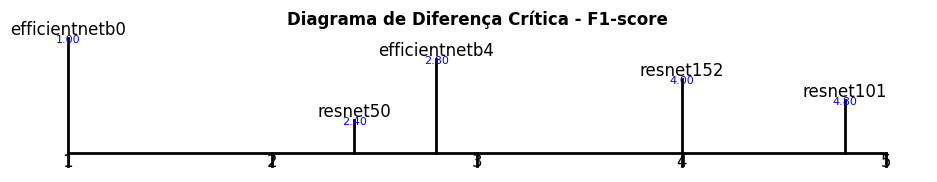

In [ ]:
# ------------------------------
# Exemplo de uso da classe
# ------------------------------
if __name__ == "__main__":

    f1_scores = {
        #"facebook_vit-mae-base": [0.4976181137777584, 0.5738939804157195, 0.5327096752238822, 0.5161515635469061, 0.5242179034378522],
        #"facebook_vit-mae-large": [0.5599959253142723, 0.6018729295971245, 0.5741766747184704, 0.6092834705265721, 0.6201362800164792],
        #"google_vit-base-patch16-224":[0.45595495275129144, 0.4629782679612371, 0.5313646506711874, 0.4637626379543192, 0.3639620913628182],
        #"google_vit-large-patch32-384": [0.47696110165735667, 0.4570572720828476, 0.5072172357338597, 0.5728776818988797, 0.4867498084990345],
        #"facebook_deit-base-patch16-384": [0.37463171951663, 0.4596120769495382, 0.5314509079832401, 0.5085419366681986, 0.4030687403113032],
        "resnet50": [0.45834325408965343, 0.4917311823183056, 0.4966061645089778, 0.501830315479528, 0.4859769521096753],
        "resnet101": [0.3831108568522757, 0.37855905816263874, 0.409396784501398, 0.3976358313617702, 0.4035407873580546],
        "resnet152": [0.407443320805029, 0.3944953881015262, 0.45261125868542745, 0.38459110172109173, 0.44951350903026777],
        "efficientnetb4": [0.4771009751828166, 0.44650255855330573, 0.5018739503587366, 0.470005115283753, 0.44902634308005146],
        "efficientnetb0": [0.508452831871046, 0.5581712902045382, 0.5535151093503496, 0.5072735988081256, 0.55884566939203],

    }


    cd_plotter = CDDiagramPlotter(f1_scores, alpha=0.05, metric_name="F1-score")
    cd_plotter.draw_cd_diagram(title="Diagrama de Diferença Crítica - F1-score", labels=True)

In [ ]:
import pandas as pd

# Dados de F1-score
f1_scores = {
        #"facebook_vit-mae-base": [0.4976181137777584, 0.5738939804157195, 0.5327096752238822, 0.5161515635469061, 0.5242179034378522],
        #"facebook_vit-mae-large": [0.5599959253142723, 0.6018729295971245, 0.5741766747184704, 0.6092834705265721, 0.6201362800164792],
        #"google_vit-base-patch16-224":[0.45595495275129144, 0.4629782679612371, 0.5313646506711874, 0.4637626379543192, 0.3639620913628182],
        #"google_vit-large-patch32-384": [0.47696110165735667, 0.4570572720828476, 0.5072172357338597, 0.5728776818988797, 0.4867498084990345],
        #"facebook_deit-base-patch16-384": [0.37463171951663, 0.4596120769495382, 0.5314509079832401, 0.5085419366681986, 0.4030687403113032],
        "resnet50": [0.45834325408965343, 0.4917311823183056, 0.4966061645089778, 0.501830315479528, 0.4859769521096753],
        "resnet101": [0.3831108568522757, 0.37855905816263874, 0.409396784501398, 0.3976358313617702, 0.4035407873580546],
        "resnet152": [0.407443320805029, 0.3944953881015262, 0.45261125868542745, 0.38459110172109173, 0.44951350903026777],
        "efficientnetb4": [0.4771009751828166, 0.44650255855330573, 0.5018739503587366, 0.470005115283753, 0.44902634308005146],
        "efficientnetb0": [0.508452831871046, 0.5581712902045382, 0.5535151093503496, 0.5072735988081256, 0.55884566939203],

    }


# Nome dos datasets (exemplo: "Fold 1", "Fold 2", etc.)
num_folds = len(next(iter(f1_scores.values())))
datasets = [f"Fold {i+1}" for i in range(num_folds)]

# Criar DataFrame no formato desejado
data = []
for model, scores in f1_scores.items():
    for dataset, score in zip(datasets, scores):
        data.append([model, dataset, score])

df = pd.DataFrame(data, columns=["classifier_name", "dataset_name", "f1-score"])

# Exibir o DataFrame
print(df)

# Salvar em CSV
df.to_csv("f1_scores_table.csv", index=False)
print("\nTabela salva como 'f1_scores_table.csv'.")


   classifier_name dataset_name  f1-score
0         resnet50       Fold 1  0.458343
1         resnet50       Fold 2  0.491731
2         resnet50       Fold 3  0.496606
3         resnet50       Fold 4  0.501830
4         resnet50       Fold 5  0.485977
5        resnet101       Fold 1  0.383111
6        resnet101       Fold 2  0.378559
7        resnet101       Fold 3  0.409397
8        resnet101       Fold 4  0.397636
9        resnet101       Fold 5  0.403541
10       resnet152       Fold 1  0.407443
11       resnet152       Fold 2  0.394495
12       resnet152       Fold 3  0.452611
13       resnet152       Fold 4  0.384591
14       resnet152       Fold 5  0.449514
15  efficientnetb4       Fold 1  0.477101
16  efficientnetb4       Fold 2  0.446503
17  efficientnetb4       Fold 3  0.501874
18  efficientnetb4       Fold 4  0.470005
19  efficientnetb4       Fold 5  0.449026
20  efficientnetb0       Fold 1  0.508453
21  efficientnetb0       Fold 2  0.558171
22  efficientnetb0       Fold 3  0

In [ ]:
!pip install 'critdd @ git+https://github.com/mirkobunse/critdd'


In [ ]:
!apt-get install texlive-latex-base
!apt-get install texlive-latex-base texlive-pictures texlive-latex-extra

In [ ]:
from critdd import Diagram
import pandas as pd

# download example data
_URL = "./f1_scores_table.csv"
df = pd.read_csv(_URL).pivot(
    index = "dataset_name",
    columns = "classifier_name",
    values = "f1-score"
)

# create a CD diagram from the Pandas DataFrame
diagram = Diagram(
    df.to_numpy(),
    treatment_names = df.columns,
    maximize_outcome = True
)

# inspect average ranks and groups of statistically indistinguishable treatments
print(diagram.average_ranks) # the average rank of each treatment
diagram.get_groups(alpha=.05, adjustment="holm") #holm

# export the diagram to a file
diagram.to_file(
    "example.pdf",
    alpha = .05,
    adjustment = "holm", #holm
    reverse_x = True,
    axis_options = {"title": "critdd"},
)

[1.  2.8 4.8 4.  2.4]


In [ ]:
!pdflatex example.tex

# Rodar Testes Estatísticos (Friedman + Nemenyi)

Para verificar se a diferença entre CNNs e ViTs é estatisticamente significativa, aplicamos:

1.  Teste de Friedman para comparar todos os modelos.
2.  Pós-Teste de Nemenyi para identificar quais diferenças são estatisticamente significativas.

In [ ]:
import numpy as np
from scipy.stats import friedmanchisquare
from scikit_posthocs import posthoc_nemenyi_friedman

# F1-scores médios por modelo
'''
f1_scores = {
    "facebook_vit-mae-base": [0.6674] * 5,
    "facebook_vit-mae-large": [0.7017] * 5,
    "google_vit-base-patch16-224": [0.6029] * 5,
    "google_vit-large-patch32-384": [0.6406] * 5,
    "ConvNeXt_Large": [0.8825] * 5,
    "ConvNeXt_Base": [0.8716] * 5,
    "ResNet152": [0.8528] * 5
}
'''
f1_scores = {
        #"facebook_vit-mae-base": [0.4976181137777584, 0.5738939804157195, 0.5327096752238822, 0.5161515635469061, 0.5242179034378522],
        #"facebook_vit-mae-large": [0.5599959253142723, 0.6018729295971245, 0.5741766747184704, 0.6092834705265721, 0.6201362800164792],
        #"google_vit-base-patch16-224":[0.45595495275129144, 0.4629782679612371, 0.5313646506711874, 0.4637626379543192, 0.3639620913628182],
        #"google_vit-large-patch32-384": [0.47696110165735667, 0.4570572720828476, 0.5072172357338597, 0.5728776818988797, 0.4867498084990345],
        #"facebook_deit-base-patch16-384": [0.37463171951663, 0.4596120769495382, 0.5314509079832401, 0.5085419366681986, 0.4030687403113032],
        "resnet50": [0.45834325408965343, 0.4917311823183056, 0.4966061645089778, 0.501830315479528, 0.4859769521096753],
        "resnet101": [0.3831108568522757, 0.37855905816263874, 0.409396784501398, 0.3976358313617702, 0.4035407873580546],
        "resnet152": [0.407443320805029, 0.3944953881015262, 0.45261125868542745, 0.38459110172109173, 0.44951350903026777],
        "efficientnetb4": [0.4771009751828166, 0.44650255855330573, 0.5018739503587366, 0.470005115283753, 0.44902634308005146],
        "efficientnetb0": [0.508452831871046, 0.5581712902045382, 0.5535151093503496, 0.5072735988081256, 0.55884566939203],

    }

# Converter para matriz NumPy
results_array = np.array(list(f1_scores.values()))

# Teste de Friedman
statistic, p_value = friedmanchisquare(*results_array)
print(f"\nTeste de Friedman (CNNs vs. ViTs): estatística={statistic:.4f}, p-valor={p_value:.4f}")

if p_value < 0.05:
    print("\nHá diferença significativa! Executando Pós-Teste de Nemenyi...\n")

    # Pós-Teste de Nemenyi
    nemenyi_results = posthoc_nemenyi_friedman(results_array.T)
    print(nemenyi_results)
else:
    print("\nNão há diferença estatística significativa entre CNNs e ViTs.")



Teste de Friedman (CNNs vs. ViTs): estatística=17.2800, p-valor=0.0017

Há diferença significativa! Executando Pós-Teste de Nemenyi...

          0         1         2         3         4
0  1.000000  0.115233  0.497325  0.994615  0.627659
1  0.115233  1.000000  0.930677  0.265889  0.001363
2  0.497325  0.930677  1.000000  0.751424  0.022659
3  0.994615  0.265889  0.751424  1.000000  0.373481
4  0.627659  0.001363  0.022659  0.373481  1.000000


# Gerar Gráficos Comparativos
📊 Boxplot CNNs vs. ViTs

<ipython-input-14-e21657600b26>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Modelo", y="F1-score", data=df, palette="coolwarm")


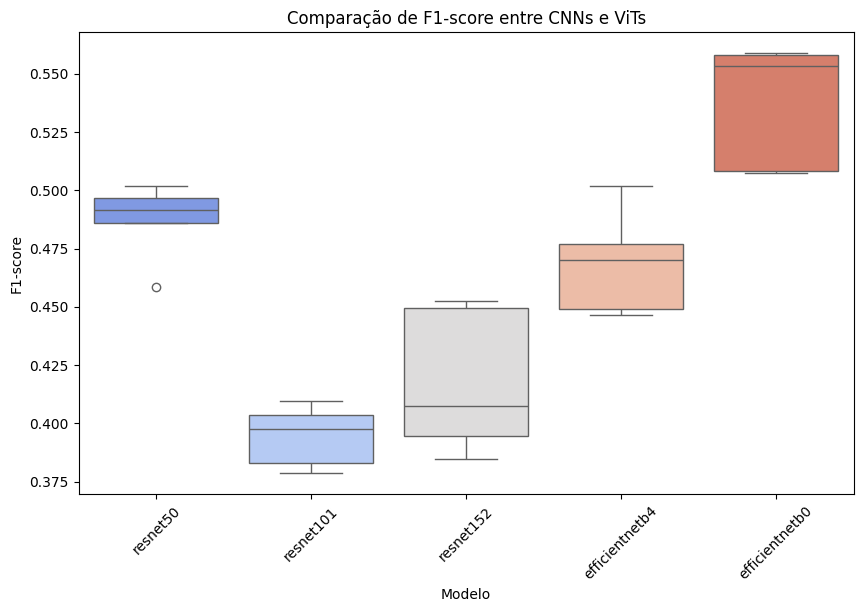

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Criar DataFrame para visualização

data = []
for model, scores in f1_scores.items():
    for score in scores:
        data.append([model, score])

df = pd.DataFrame(data, columns=["Modelo", "F1-score"])

# Criar Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x="Modelo", y="F1-score", data=df, palette="coolwarm")
plt.xticks(rotation=45)
plt.title("Comparação de F1-score entre CNNs e ViTs")
plt.show()
